In [1]:
##########----- Reused code -----##########
# Last update: Dec 6th, 2020
# By: Huitian Diao
# Python3.8 environment: sc_py3.8
###########################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import os
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import DBSCAN
import warnings
from pathlib import Path
from scipy import stats

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

warnings.filterwarnings('ignore')
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.4 numpy==1.19.2 scipy==1.5.2 pandas==1.0.5 scikit-learn==0.23.2 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.6.1 leidenalg==0.8.1


In [2]:
###----- Get dir & load / reload packages
try:
    code_dir
except NameError:
    print("Start")
    code_dir = os.getcwd()
    base_dir = code_dir.replace("/codes_local","")
    root_dir = "/".join(base_dir.split("/")[:-1])

    wk_dir = base_dir + "/0_input"
    Path(wk_dir).mkdir(parents=True, exist_ok=True)
else:
    print("Reload")

Start


In [3]:
os.chdir(wk_dir)
input_dir = wk_dir

---
# Read data

In [4]:
JC_file = input_dir + '/GSE89405_Kakaradov_singlecell_expression_matrix.csv'
JC_df = pd.read_csv(JC_file)

JC_df.columns = ['index', 'cell_id'] + JC_df.columns.tolist()[2:]
del JC_df['index']
JC_df.head()
JC_df = JC_df.set_index('cell_id')

adata = sc.AnnData(JC_df)

In [42]:
meta_file = input_dir + '/SraRunTable.csv'
meta_df = pd.read_csv(meta_file)
meta_df = meta_df[meta_df['Replicate'].notna()][['subtype','Replicate']]
meta_df = meta_df.set_index('Replicate')

## Configuration

In [18]:
min_gene_nu, min_cell_nu = 500, 3 # Minimum cell number for cell filtering

min_g, max_g = 4000, 15000
min_m, max_m = 0.00, 0.015
min_c, max_c = 4000, 50000

fa_n, fa_pc = 50, 30

max_n_per_cond = 1250 # Maximun number of cells to use per condition

In [6]:
# Mitochondrial genes
mito_genes = adata.var_names.str.startswith('mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)
# add genes per cell
n_genes = []
for i in range(JC_df.shape[0]):
    n_genes.append(len([x for x in JC_df.iloc[i,:] if x != 0]))
adata.obs['n_genes'] = n_genes

(0.0, 1.0, 0.0, 1.0)

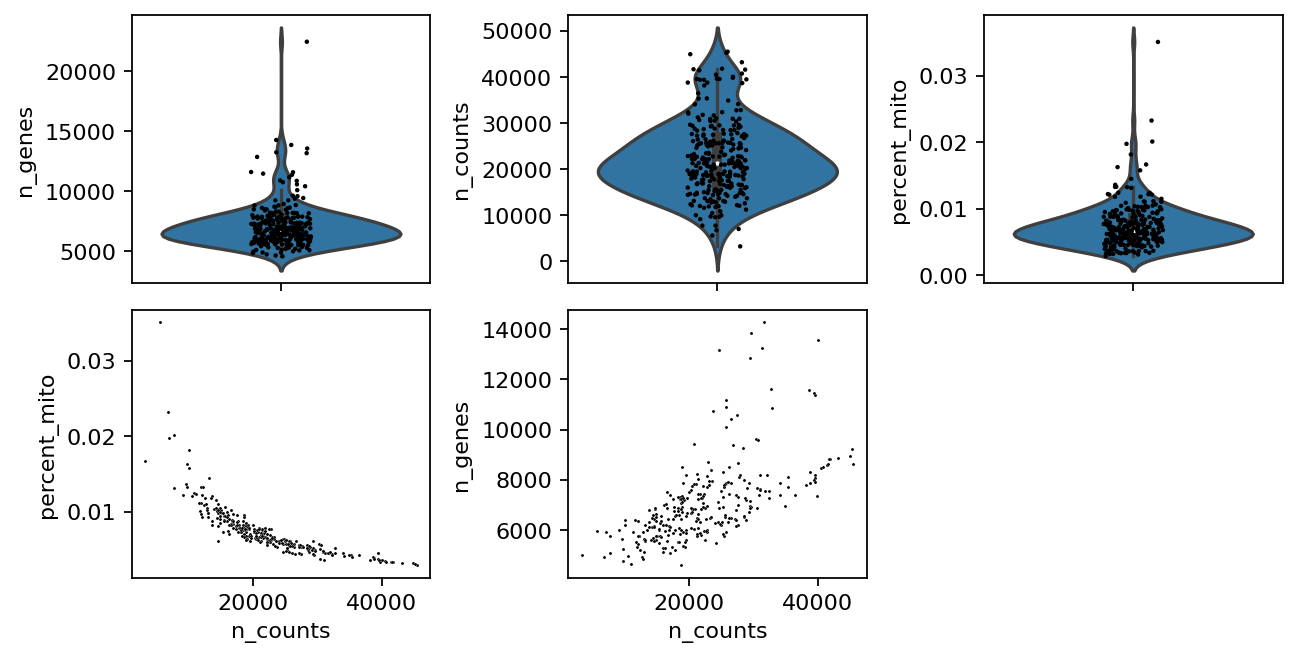

In [7]:
# Pre filtering QC plots
fig, axes = plt.subplots(ncols=3, nrows=2, sharey=False, 
                         figsize=(8,4), constrained_layout = True, dpi=160)

sns.violinplot(y=adata.obs['n_genes'], ax=axes[0,0])
sns.stripplot(y=adata.obs['n_genes'], color='black', s=2, ax=axes[0,0])

sns.violinplot(y=adata.obs['n_counts'], ax=axes[0,1])
sns.stripplot(y=adata.obs['n_counts'], color='black', s=2, ax=axes[0,1])

sns.violinplot(y=adata.obs['percent_mito'], ax=axes[0,2])
sns.stripplot(y=adata.obs['percent_mito'], color='black', s=2, ax=axes[0,2])

sns.scatterplot(x=adata.obs['n_counts'], y=adata.obs['percent_mito'], 
                ax=axes[1,0], color='black', s=2)
sns.scatterplot(x=adata.obs['n_counts'], y=adata.obs['n_genes'], 
                ax=axes[1,1], color='black', s=2)

axes[-1][-1].axis('off')

In [8]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=min_gene_nu)
sc.pp.filter_genes(adata, min_cells=min_cell_nu)

use_list = []
for i in range(len(adata.obs)):
    i_genes = ((adata.obs['n_genes'][i] >= min_g) and (adata.obs['n_genes'][i] <= max_g))
    i_mito = ((adata.obs['percent_mito'][i] >= min_m) and (adata.obs['percent_mito'][i] <= max_m))
    i_c = ((adata.obs['n_counts'][i] >= min_c) and (adata.obs['n_counts'][i] <= max_c))
    if all([i_genes, i_mito, i_c]):
        use_list.append(True)
    else:
        use_list.append(False)

adata = adata[use_list, :]

(0.0, 1.0, 0.0, 1.0)

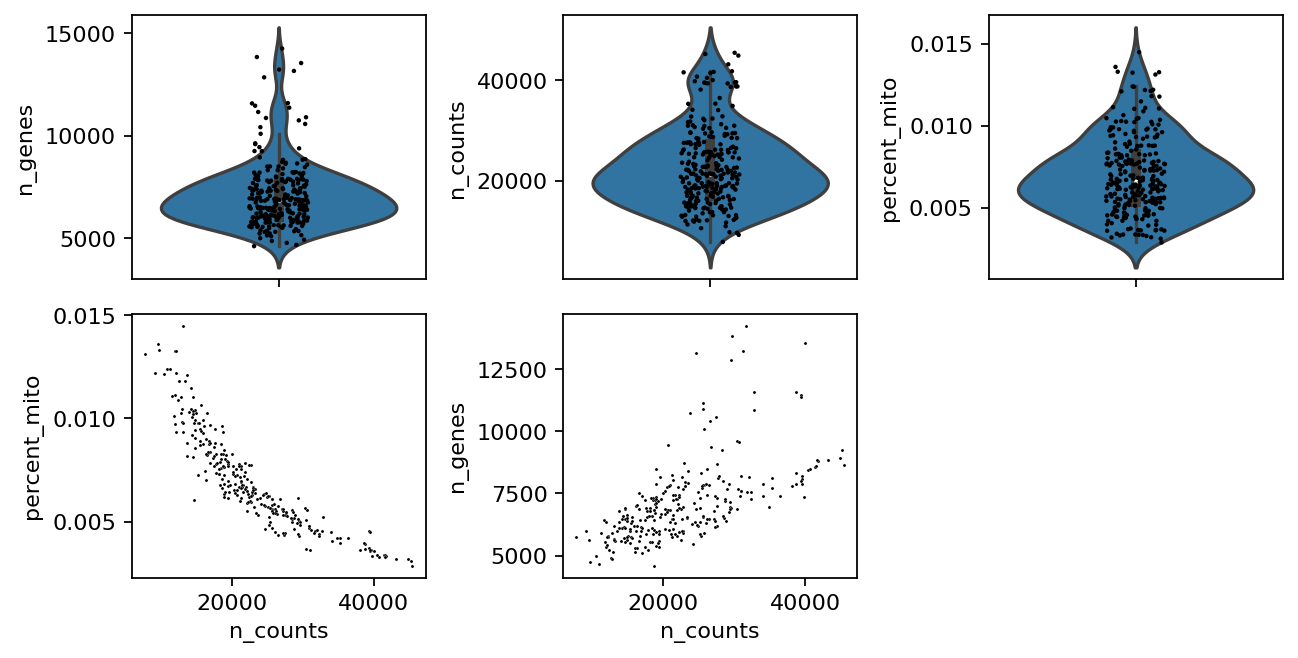

In [9]:
# Post filtering QC plots
fig, axes = plt.subplots(ncols=3, nrows=2, sharey=False, 
                         figsize=(8,4), constrained_layout = True, dpi=160)

sns.violinplot(y=adata.obs['n_genes'], ax=axes[0,0])
sns.stripplot(y=adata.obs['n_genes'], color='black', s=2, ax=axes[0,0])

sns.violinplot(y=adata.obs['n_counts'], ax=axes[0,1])
sns.stripplot(y=adata.obs['n_counts'], color='black', s=2, ax=axes[0,1])

sns.violinplot(y=adata.obs['percent_mito'], ax=axes[0,2])
sns.stripplot(y=adata.obs['percent_mito'], color='black', s=2, ax=axes[0,2])

sns.scatterplot(x=adata.obs['n_counts'], y=adata.obs['percent_mito'], 
                ax=axes[1,0], color='black', s=2)
sns.scatterplot(x=adata.obs['n_counts'], y=adata.obs['n_genes'], 
                ax=axes[1,1], color='black', s=2)

axes[-1][-1].axis('off')

Trying to set attribute `.obs` of view, copying.


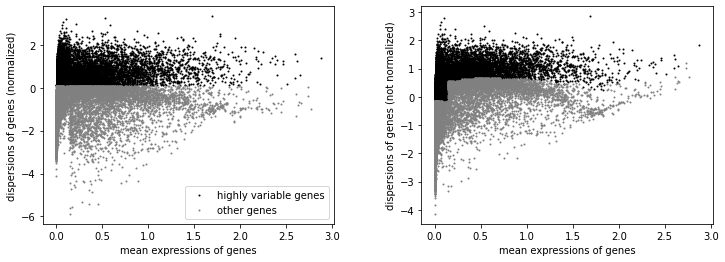

In [13]:
# Total-count normalize the data matrix to 10,000 reads per cell, so the counts become comparable among cells
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# Logarithmize the data
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.002, max_mean=10, min_disp=0.1)
sc.pl.highly_variable_genes(adata)

adata.raw = adata
adata = adata[:, adata.var['highly_variable']]
sc.pp.regress_out(adata, ['n_counts'])
sc.pp.scale(adata, max_value=10) 

# Write for Harmony
write_flag = True
if write_flag:
    raw_array = adata.X
    pd_raw_df = pd.DataFrame(raw_array)
    pd_raw_df.columns = list(adata.var.index.values)
    col_names = list(pd_raw_df.columns.values)
    pd_raw_df.index = list(adata.obs.index.values)
    pd_raw_df.to_csv("all_norm_counts_named_log_scaled.csv")     

In [19]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=fa_n, n_pcs=fa_pc)
sc.tl.draw_graph(adata)

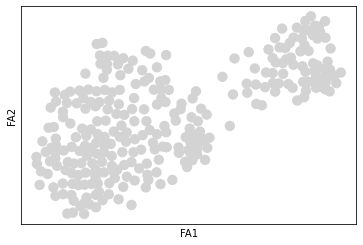

In [20]:
sc.pl.draw_graph(adata)

In [46]:
adata.obs = adata.obs.join(meta_df)

... storing 'subtype' as categorical


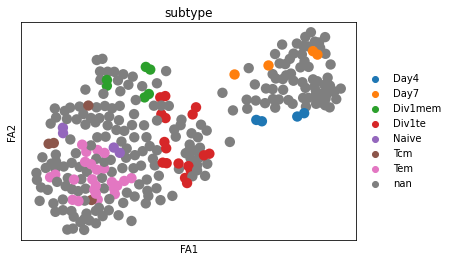

In [47]:
sc.pl.draw_graph(adata, color='subtype')